In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

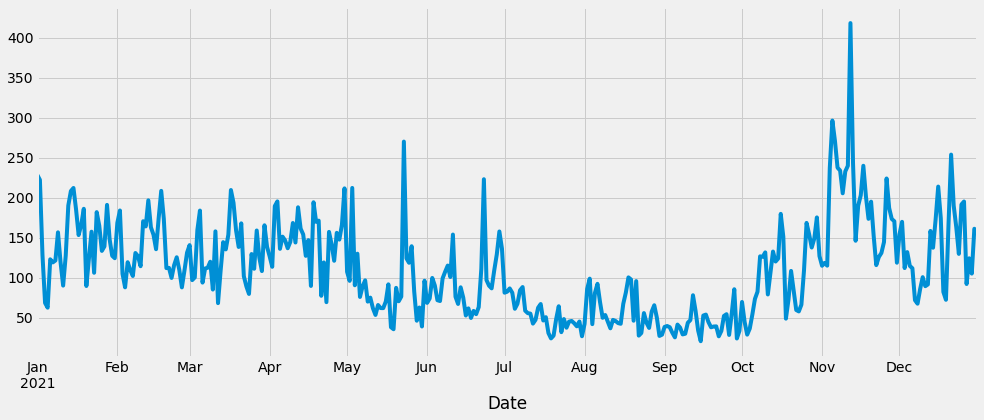

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC: 4549.710802289167
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC: 4185.430650595204
ARIMA(0, 0, 0) x (0, 0, 2, 12) - AIC: 3933.691724428268
ARIMA(0, 0, 0) x (0, 0, 3, 12) - AIC: 3753.403427705967
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC: 3907.8260557900676
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC: 3697.1467635311396
ARIMA(0, 0, 0) x (0, 1, 2, 12) - AIC: 3572.0450178637493
ARIMA(0, 0, 0) x (0, 1, 3, 12) - AIC: 3448.177831167387
ARIMA(0, 0, 0) x (0, 2, 0, 12) - AIC: 4115.885931209275
ARIMA(0, 0, 0) x (0, 2, 1, 12) - AIC: 3683.541663611488
ARIMA(0, 0, 0) x (0, 2, 2, 12) - AIC: 3489.2666289616136
ARIMA(0, 0, 0) x (0, 2, 3, 12) - AIC: 3362.605137700115
ARIMA(0, 0, 0) x (0, 3, 0, 12) - AIC: 4238.410908851734
ARIMA(0, 0, 0) x (0, 3, 1, 12) - AIC: 3794.6672421677067
ARIMA(0, 0, 0) x (0, 3, 2, 12) - AIC: 3579.168696097607
ARIMA(0, 0, 0) x (0, 3, 3, 12) - AIC: 3446.3679096675996
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC: 3900.6513292069885
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC: 382

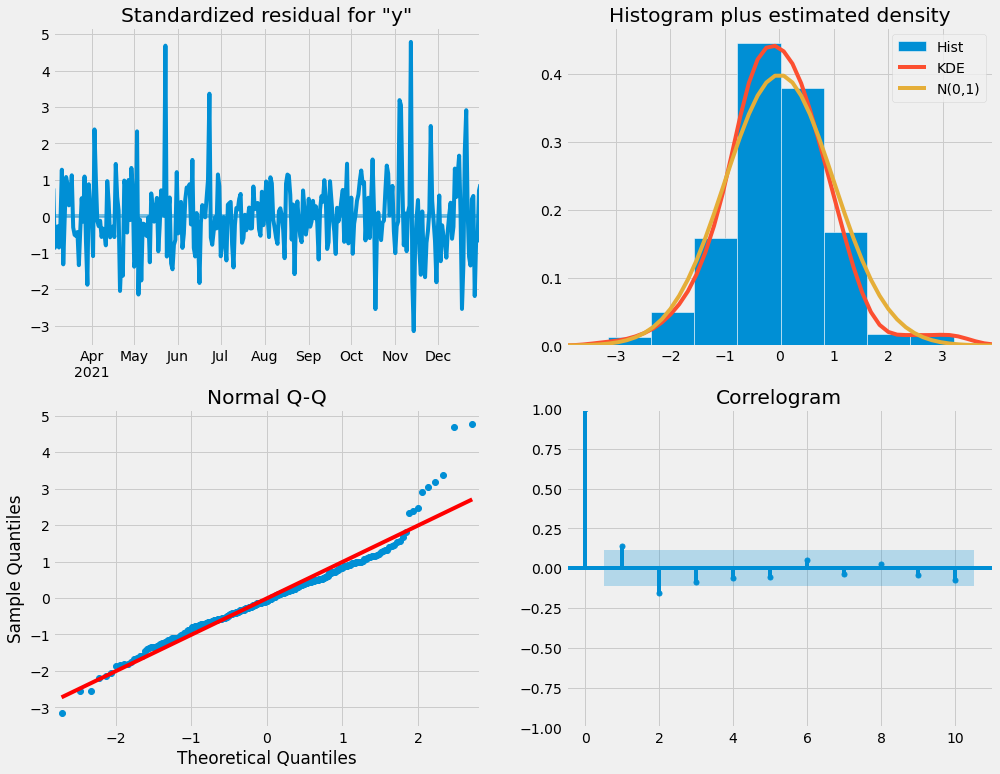

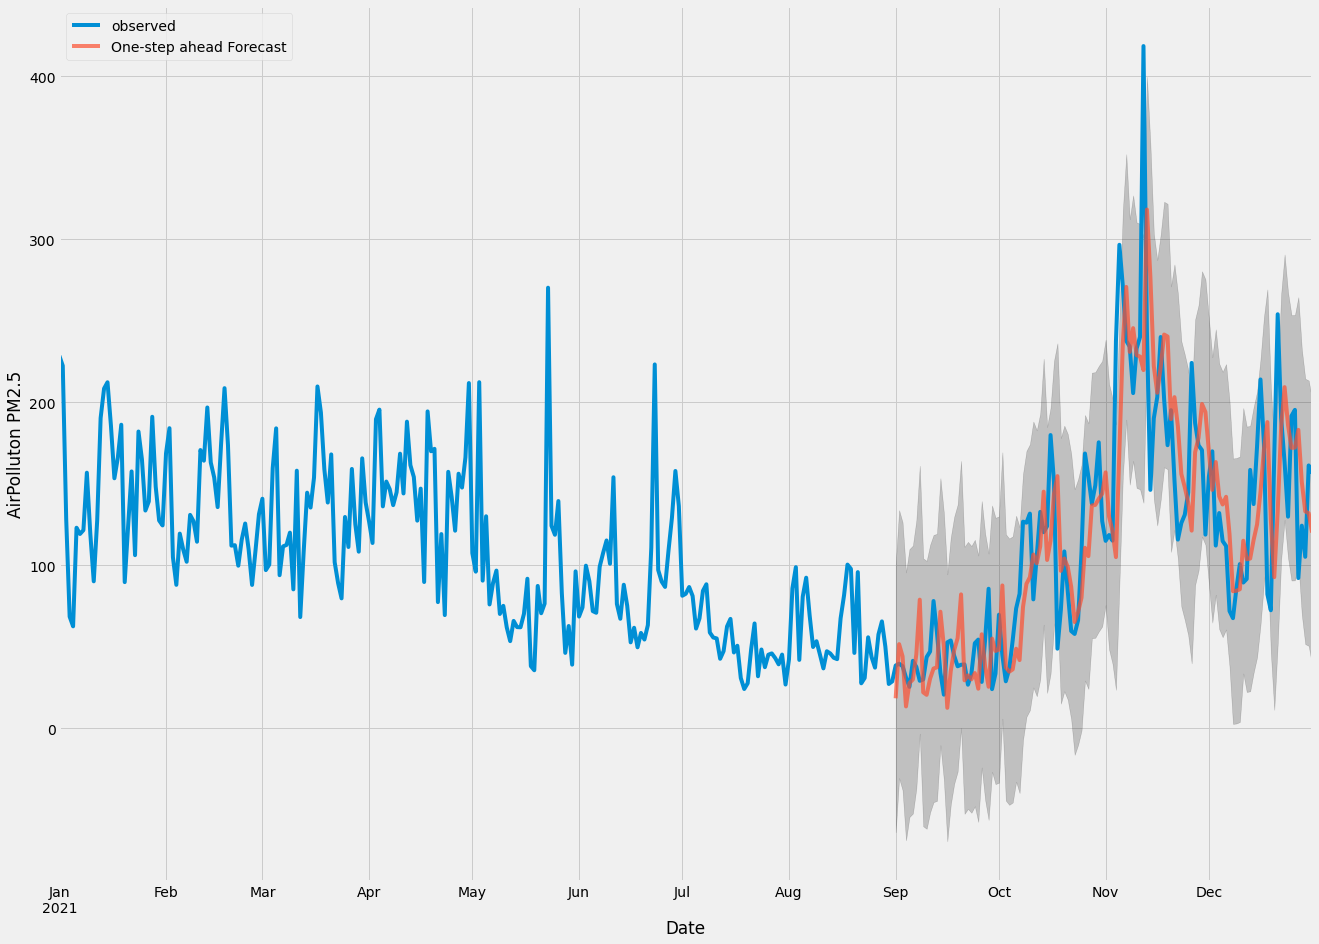

The Mean Squared Error of our forecasts is 2175.59


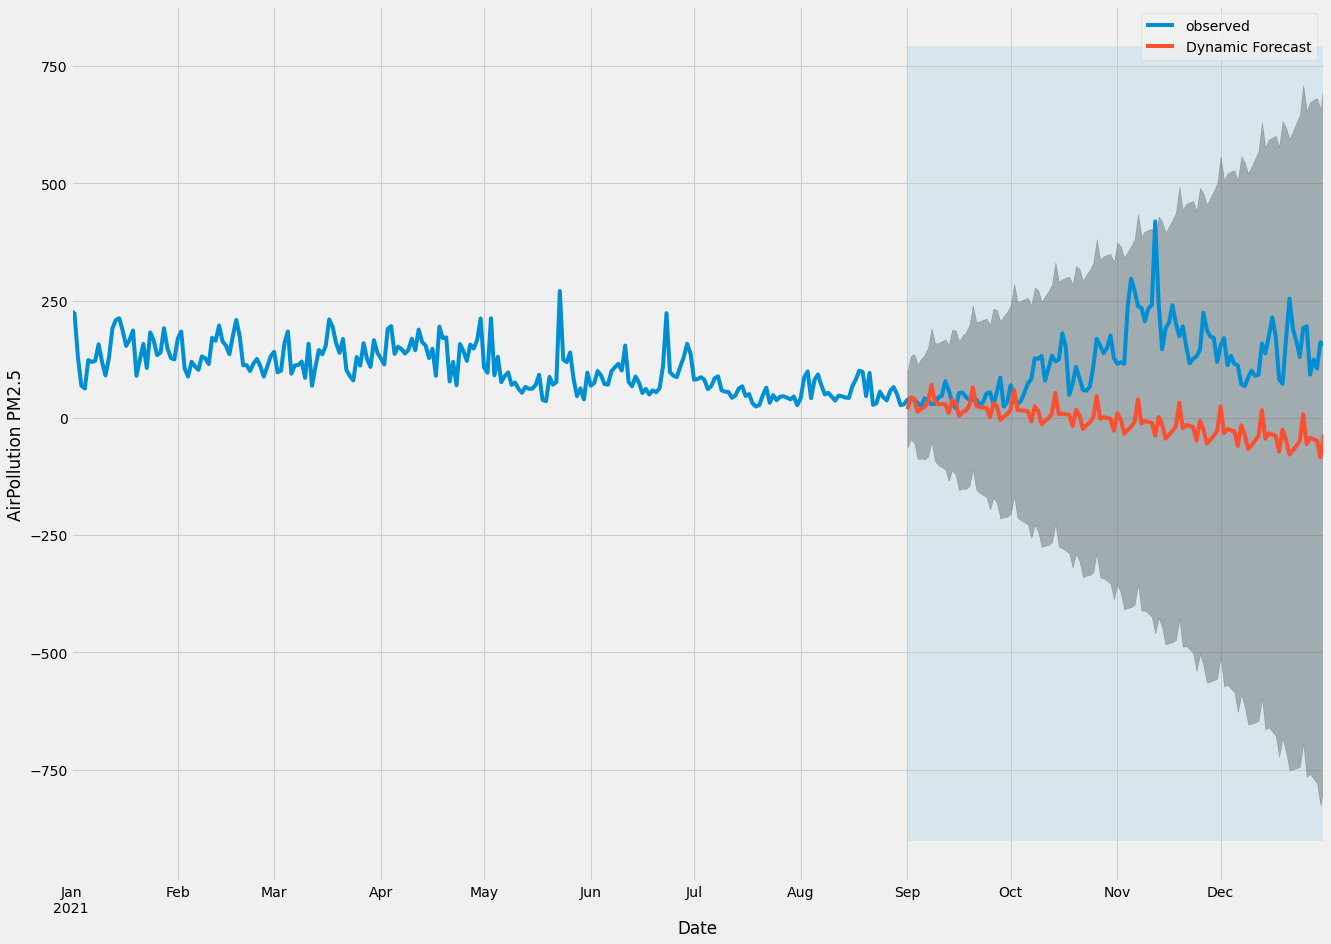

The Mean Squared Error of our forecasts is 24215.72


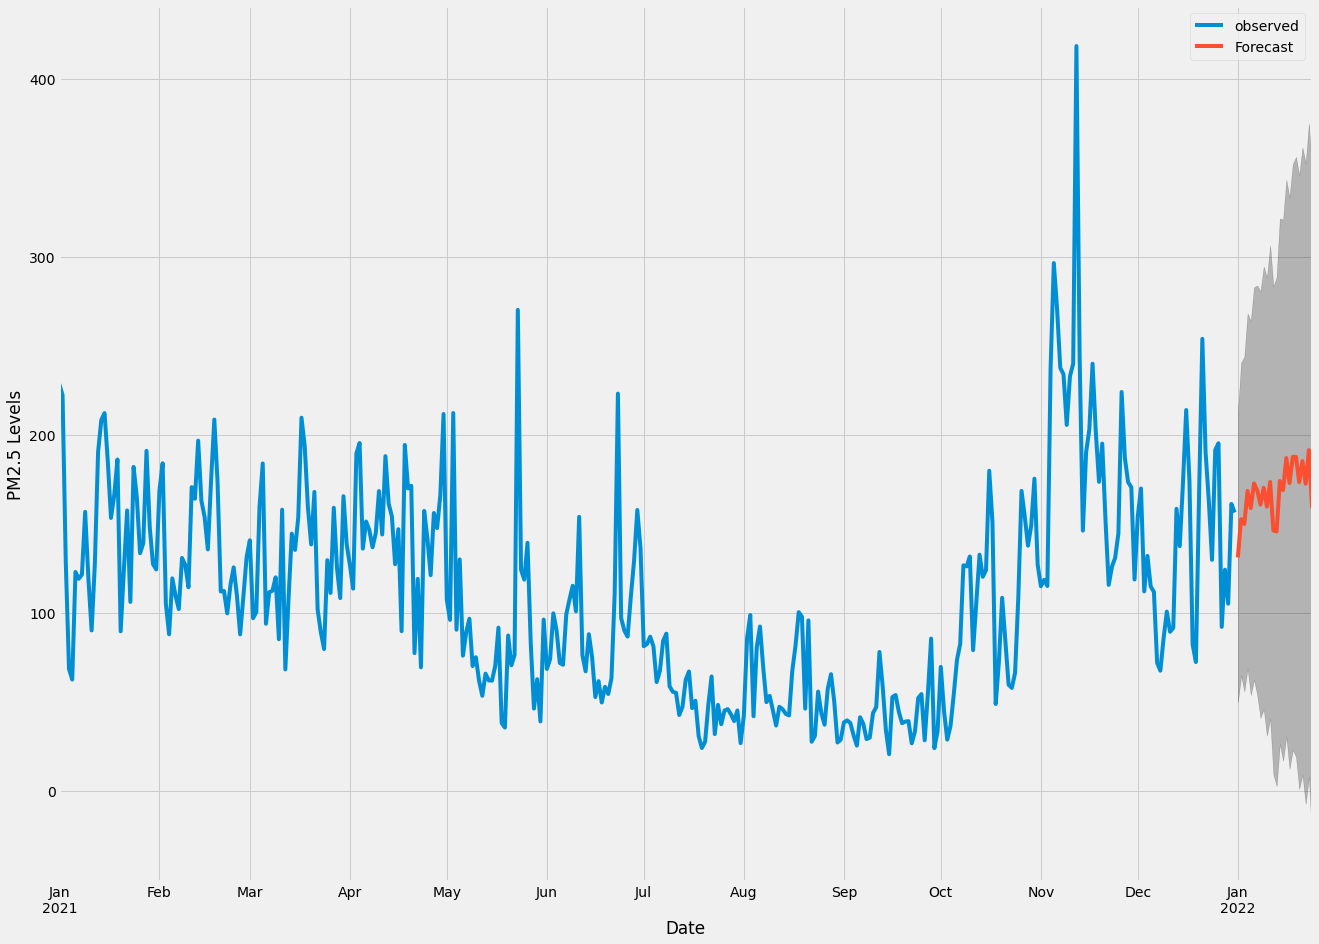

In [2]:
df = pd.read_csv(r"E:\New\arima_air_pol\Bhiwadi1.csv")

df.head()

df['Date'] = pd.to_datetime(df['Date'])


df.head()

y = pd.Series(data=df['PM2.5'].values, index=df['Date'])

y.head()

y.plot(figsize=(15, 6))
plt.show()

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


warnings.filterwarnings("ignore") # specify to ignore warning messages

best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
            
print('\nBest Result:', best_result)


mod = sm.tsa.statespace.SARIMAX(y,
                                order=(best_result[0][0], best_result[0][1], best_result[0][1]),
                                seasonal_order=(best_result[1][0], best_result[1][1], best_result[1][2], best_result[1][3]),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])


results.plot_diagnostics(figsize=(15, 12))
plt.show()

pred = results.get_prediction(start=pd.to_datetime('2021-09-01'), dynamic=False)
pred_ci = pred.conf_int()


ax = y['2021':].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('AirPolluton PM2.5')
plt.legend()

plt.show()


# Extract the predicted and true values of our time series
y_forecasted = pred.predicted_mean
y_truth = y['2021-09-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


pred_dynamic = results.get_prediction(start=pd.to_datetime('2021-09-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()


ax = y['1949':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-09-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('AirPollution PM2.5')

plt.legend()
plt.show()

# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2021-09-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


# Get forecast 24 steps (24 days) ahead in future
pred_uc = results.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()


ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5 Levels')

plt.legend()
plt.show()